In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def open_data(filename):
    return pd.read_csv(filename, delimiter=' ').values

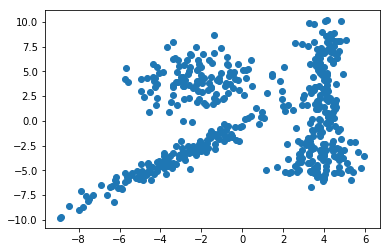

In [13]:
train = open_data('EMGaussian.data')

plt.scatter(train[:, 0], train[:, 1])

In [108]:
class KMeans:
    def __init__(self, k=2):
        self.k = k
        
    def fit(self, X):
        self.k_centers = np.random.random(size=(X.shape[1], self.k))

        for i in range(10000):
            dists = np.sum((X[:, :, np.newaxis] - self.k_centers)**2, axis=1)
            cluster_assignement = np.argmin(dists, axis=1)
            
            for cluster_n in range(self.k):
                self.k_centers[:, cluster_n] = np.mean(X[cluster_assignement==cluster_n, :], axis=0)
    
    def predict(self, X):       
        dists = np.sum((X[:, :, np.newaxis] - self.k_centers)**2, axis=1)
        cluster_assignement = np.argmin(dists, axis=1)  
        return cluster_assignement

In [125]:
km = KMeans(k=5)
km.fit(train)

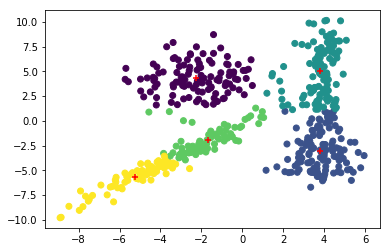

In [126]:
plt.scatter(train[:, 0], train[:, 1], c=km.predict(train))
plt.scatter(km.k_centers[0, :], km.k_centers[1, :], c='red', marker='+')